In [1]:
import torch
import numpy as np
from tqdm import tqdm
from qai_hub_models.models.ffnet_40s import Model as FFNetModel
import torch
import lightning as L
from torch.nn import functional as F
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import random
from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime
from typing import Tuple
from matplotlib import pyplot as plt
import numpy as np

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

/home/agorski/Desktop/projects/ENNCA-agorski/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading data

In [2]:
train_input_path = '../02_processed/train'
val_input_path = '../02_processed/val'

In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, path: str):
        images, masks = ImageDataset.load_images(path)
        self.images = images
        self.masks = masks
    
    @staticmethod
    def load_images(path: str):
        files = glob(os.path.join(path, '*.npy'))
        image_paths = sorted(list(filter(lambda p: 'image' in p, files)))
        mask_paths = sorted(list(filter(lambda p: 'mask' in p, files)))
        images = list(tqdm(map(np.load, image_paths), total=len(image_paths)))
        masks = list(tqdm(map(np.load, mask_paths), total=len(mask_paths)))
        
        return images, masks

    def __len__(self):
        return min(len(self.images), len(self.masks))
    
    def __getitem__(self, idx: int):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask

In [4]:
train_ds = ImageDataset(train_input_path)
val_ds = ImageDataset(val_input_path)

100%|██████████| 500/500 [00:07<00:00, 69.74it/s]


In [5]:
BATCH_SIZE = 4
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

# Model definition

In [6]:
import torch
import torch.nn as nn

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super(InvertedResidualBlock, self).__init__()

        self.stride = stride
        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, in_channels * expansion, kernel_size=3, stride=stride, padding=1, groups=in_channels * expansion, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer(out)
        out = self.pointwise_layer(out)

        return out

class InvertedResidualBlockTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, t=6, stride=1):
        super(InvertedResidualBlockTranspose, self).__init__()

        self.stride = stride

        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, in_channels * t, kernel_size=3, stride=stride, padding=1,
                               output_padding=(0 if stride == 1 else 1), groups=in_channels * t, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer_transpose(out)
        out = self.pointwise_layer_transpose(out)

        return out


class MobileNetEncoder(nn.Module):
    def __init__(self, in_channels=3):
        super(MobileNetEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            InvertedResidualBlock(32, 16, 1, 1),
            InvertedResidualBlock(16, 24, 6, 2),
            InvertedResidualBlock(24, 24, 6, 1),
            InvertedResidualBlock(24, 32, 6, 2),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 64, 6, 2),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 160, 6, 2),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 320, 6, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [1]:
class EncoderDecoderModel(L.LightningModule):
    def __init__(self, num_classes: int = 3) -> None:
        super().__init__()
        self.num_classes_ = num_classes
        self.encoder = MobileNetEncoder()
        self.encoder_conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.encoder_upsample = nn.Upsample(size=(1024, 2048), mode='bilinear', align_corners=False)
        self.decoder = FFNetModel.from_pretrained()
        self.decoder_upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)
        # segmentation head
        self.decoder_conv = nn.Conv2d(in_channels=19, out_channels=num_classes, kernel_size=1, stride=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        enc_output = self.encoder(x)
        enc_output = enc_output[:, 159:162, :, :]
        enc_conv = self.encoder_conv(enc_output)
        enc_upsampled = self.encoder_upsample(enc_conv)
        dec_output = self.decoder(enc_upsampled)
        dec_upsampled = self.decoder_upsample(dec_output)
        dec_conv = self.decoder_conv(dec_upsampled)
        output_tensor = torch.sigmoid(dec_conv)
        return output_tensor
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        x, y = batch
        y = y.to(torch.float)
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.log("train_step_loss", loss.item(), on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log("train_epoch_loss", loss.item(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        y = y.to(torch.float)
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.log("val_step_loss", loss.item(), on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log("val_epoch_loss", loss.item(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    

NameError: name 'L' is not defined

In [8]:
model = EncoderDecoderModel(num_classes=12)

Loading pretrained model state dict from /home/agorski/.qaihm/models/ffnet/v1/ffnet40S/ffnet40S_dBBB_cityscapes_state_dict_quarts.pth
Initializing ffnnet40S_dBBB_mobile weights


In [9]:
run_id = str(datetime.now())
checkpoint_path = os.path.join('../models', run_id)

os.makedirs(checkpoint_path, exist_ok=True)


checkpoint_callback = ModelCheckpoint(
        every_n_epochs=1,
        save_top_k=-1,
        dirpath=checkpoint_path
    )

# Training

In [10]:
MAX_EPOCHS = 30
TRAIN_BATCHES = 700
VAL_BATCHES = 400

trainer = L.Trainer(max_epochs=MAX_EPOCHS, limit_train_batches=TRAIN_BATCHES, limit_val_batches=VAL_BATCHES, callbacks=[checkpoint_callback, ])
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | encoder          | MobileNetEncoder | 1.8 M 
1 | encoder_conv     | Conv2d           | 84    
2 | encoder_upsample | Upsample         | 0     
3 | decoder          | FFNet40S         | 13.9 M
4 | decoder_upsample | Upsample         | 0     
5 | decoder_conv     | Conv2d           | 240   
-------------------------------------------

/home/agorski/Desktop/projects/ENNCA-agorski/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 14:  30%|███       | 3/10 [00:01<00:04,  1.51it/s, v_num=2, train_step_loss=0.149, val_step_loss=0.164, val_epoch_loss=0.158, train_epoch_loss=0.175] 

# Model sanity check

In [20]:
images_masks_predictions = []
num_display_samples = 10
sample_ids = set(random.sample(list(np.arange(0, len(val_ds))), k=num_display_samples))
for counter, (x, y) in enumerate(val_ds):
    if counter not in sample_ids:
        continue
    model_output = model(torch.from_numpy(x).unsqueeze(0))
    img3 = model_output.squeeze(0).detach().numpy()
    y = np.argmax(y, axis=0)
    img3 = np.argmax(img3, axis=0)

    images_masks_predictions.append( (
        np.transpose(x, (1, 2, 0)),
        y,
        img3
    ))


100%|██████████| 10/10 [00:00<00:00, 24.73it/s]


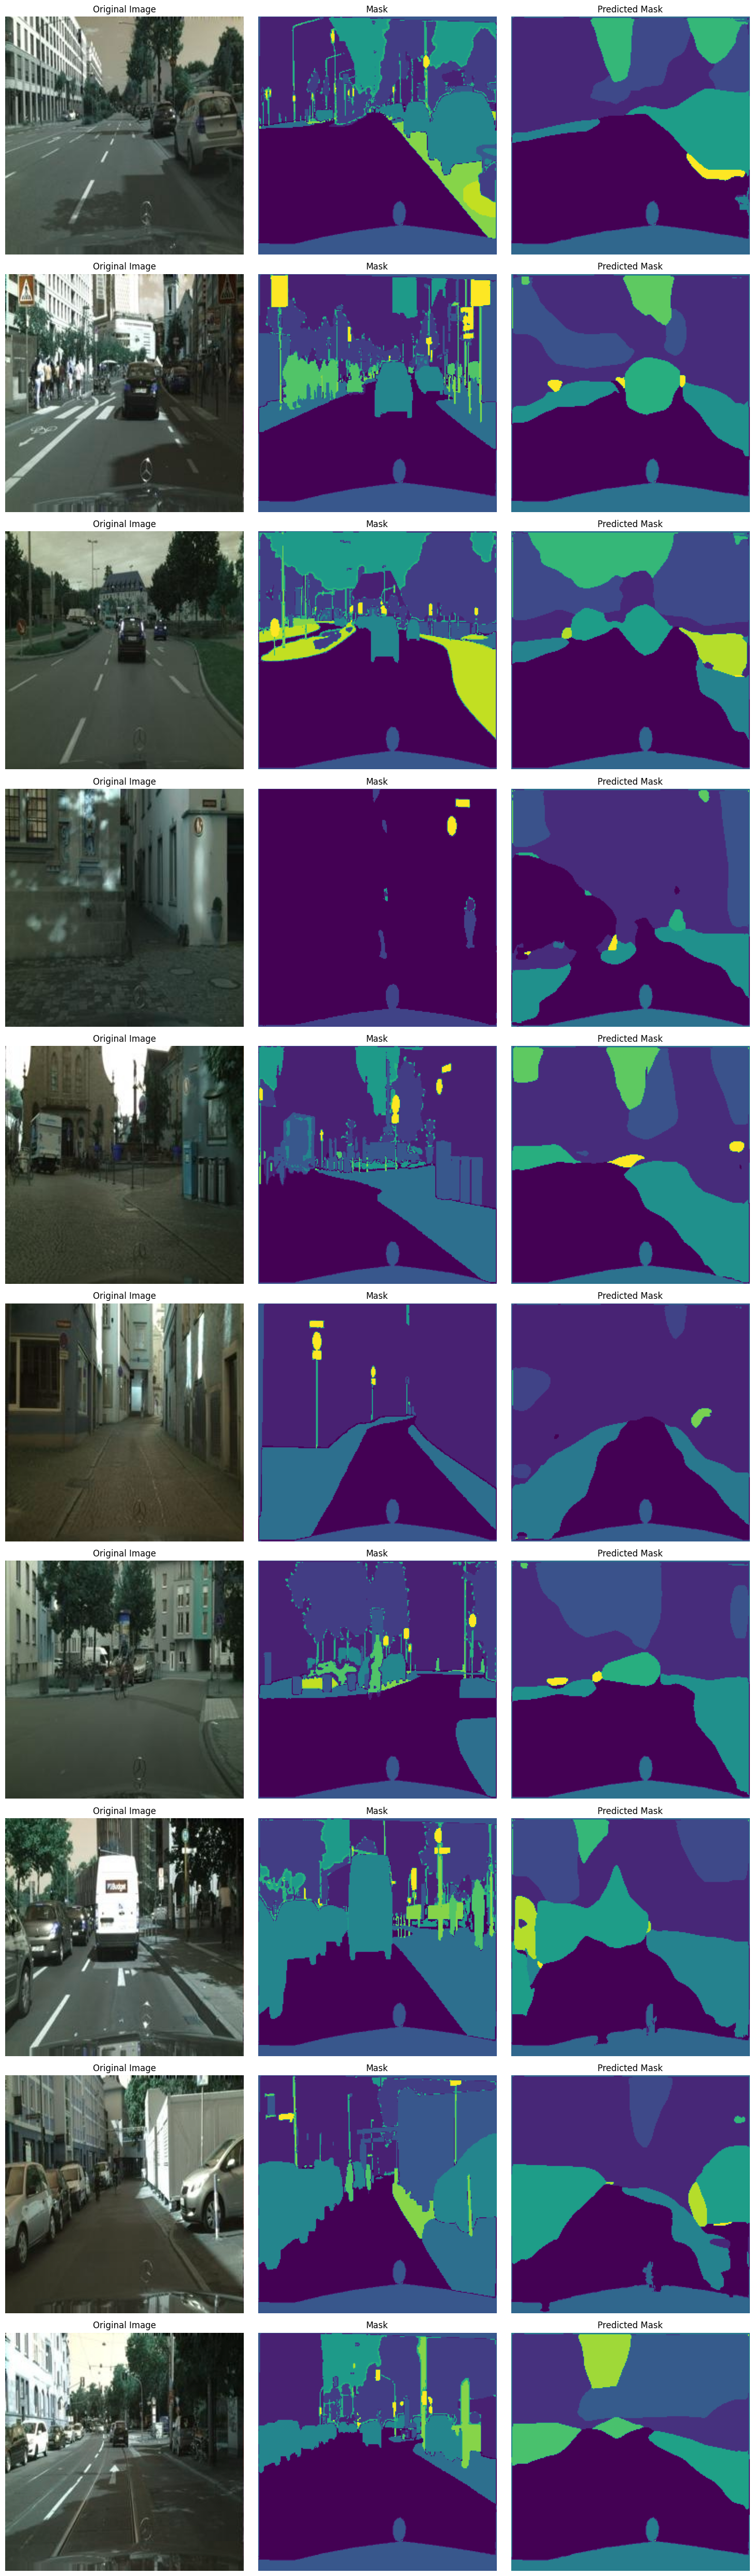

In [21]:
num_images = len(images_masks_predictions)
num_cols = 3
num_rows = num_images

plt.figure(figsize=(15, 5 * num_rows))

for i, (image, mask, mask_predicted) in tqdm(enumerate(images_masks_predictions), total=num_images):
    plt.subplot(num_rows, num_cols, num_cols * i + 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(num_rows, num_cols, num_cols * i + 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(num_rows, num_cols, num_cols * i + 3)
    plt.imshow(mask_predicted)
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()